In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import re
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
movie = pd.read_csv(r"anime.csv")
rating = pd.read_csv(r"rating.csv")

In [3]:
print(movie.shape)
print(rating.shape)

(12294, 7)
(7813737, 3)


In [4]:
datasets = [movie, rating]
def check_df(dataframe, head=10):
    print("########## First 10 Data #############")
    print(dataframe.head(head))
    print("########## Info #############")
    print(dataframe.info())
    print("########## Statistical Data #############")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("########## Null Data #############")
    print(dataframe.isnull().sum())
    print("########## Variable Types #############")
    print(dataframe.dtypes)

for each in datasets:
    check_df(each)

########## First 10 Data #############
   anime_id                                               name  \
0     32281                                     Kimi no Na wa.   
1      5114                   Fullmetal Alchemist: Brotherhood   
2     28977                                           Gintama°   
3      9253                                        Steins;Gate   
4      9969                                      Gintama&#039;   
5     32935  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   
6     11061                             Hunter x Hunter (2011)   
7       820                               Ginga Eiyuu Densetsu   
8     15335  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
9     15417                           Gintama&#039;: Enchousen   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.

In [5]:
watched_but_not_rated = rating.loc[rating["rating"] < 0,("user_id","anime_id")]
rating = rating[rating["rating"] >= 0]

In [6]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [7]:
movie.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [8]:
df = movie.merge(rating, how = "left", on = ["anime_id"])

df=df.rename(columns={'name':'anime_name','rating_y':'user_rating'})

In [9]:
movie.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [10]:
df.head(10)

,anime_id,anime_name,genre,type,episodes,rating_x,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398.0,10.0
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462.0,8.0
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490.0,10.0
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548.0,10.0
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,570.0,10.0


In [11]:
df.isnull().sum()

anime_id          0
anime_name        0
genre           118
type             28
episodes          0
rating_x        233
members           0
user_id        2368
user_rating    2368
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
anime_id,6339607.0,8908.833036,8887.263343,1.00,1239.00,6213.0,14123.00,34527.0
rating_x,6339374.0,7.674398,0.670926,1.67,7.29,7.7,8.15,10.0
members,6339607.0,184506.111482,190950.396185,5.00,46781.00,117091.0,256325.00,1013917.0
user_id,6337239.0,36747.914720,21013.406377,1.00,18984.00,36815.0,54873.00,73516.0
user_rating,6337239.0,7.808497,1.572496,1.00,7.00,8.0,9.00,10.0


[]

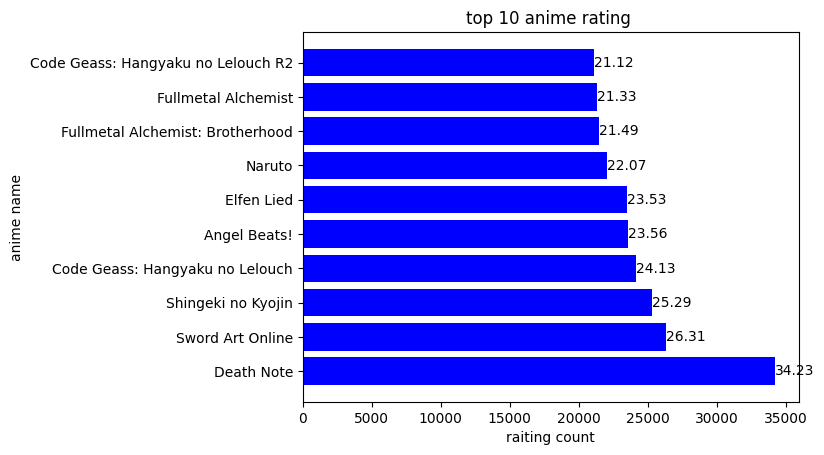

In [13]:
total_anime_rating=df.dropna(axis=0,subset=['anime_name'])
rating_count=(total_anime_rating.groupby(by=['anime_name'])['user_rating'].count().reset_index())
top_10=rating_count.sort_values(by='user_rating',ascending=False).head(10)
barh3=plt.barh(top_10['anime_name'],top_10['user_rating'],color='blue')
#plt.xticks(rotation = 45)
plt.bar_label(barh3,labels=round(top_10['user_rating']/1000,2))
plt.ylabel('anime name')
plt.title('top 10 anime rating ')
plt.xlabel('raiting count')
plt.plot()

In [14]:
top_10.head(10)

,anime_name,user_rating
2016,Death Note,34226
10435,Sword Art Online,26310
9721,Shingeki no Kyojin,25290
1709,Code Geass: Hangyaku no Lelouch,24126
427,Angel Beats!,23565
2575,Elfen Lied,23528
7428,Naruto,22071
2848,Fullmetal Alchemist: Brotherhood,21494
2847,Fullmetal Alchemist,21332
1713,Code Geass: Hangyaku no Lelouch R2,21124


In [15]:
df = df.merge(rating_count, left_on = 'anime_name', right_on = 'anime_name', how = 'left')
df = df.rename(columns={'user_rating_x': 'user_rating', 'user_rating_y': 'total_rating_count'})

In [16]:
df.head(10)

,anime_id,anime_name,genre,type,episodes,rating_x,members,user_id,user_rating,total_rating_count
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0,1961
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0,1961
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0,1961
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0,1961
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0,1961
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398.0,10.0,1961
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462.0,8.0,1961
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490.0,10.0,1961
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548.0,10.0,1961
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,570.0,10.0,1961


In [17]:
df_copy=df.copy()


In [18]:
df_copy.drop_duplicates(subset='anime_name',keep='first',inplace=True)

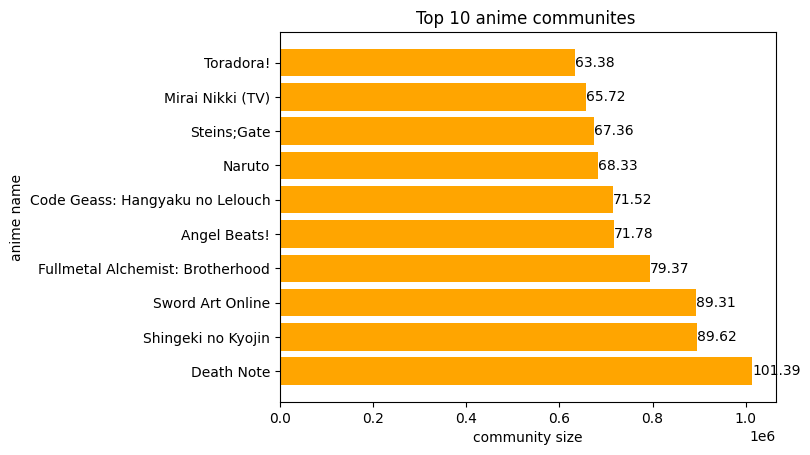

In [19]:
top_10_size=df_copy[['anime_name','members']].sort_values(by='members',ascending=False).head(10)
bar=plt.barh(top_10_size['anime_name'],top_10_size['members'],color='orange')
plt.bar_label(bar,labels=round(top_10_size['members']/10000,2))
plt.title('Top 10 anime communites ')
plt.xlabel('community size')
plt.ylabel('anime name')
plt.show()

In [20]:
plt.figure(figsize=(15,7))

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

Text(0.5, 1.0, 'Rating of users')

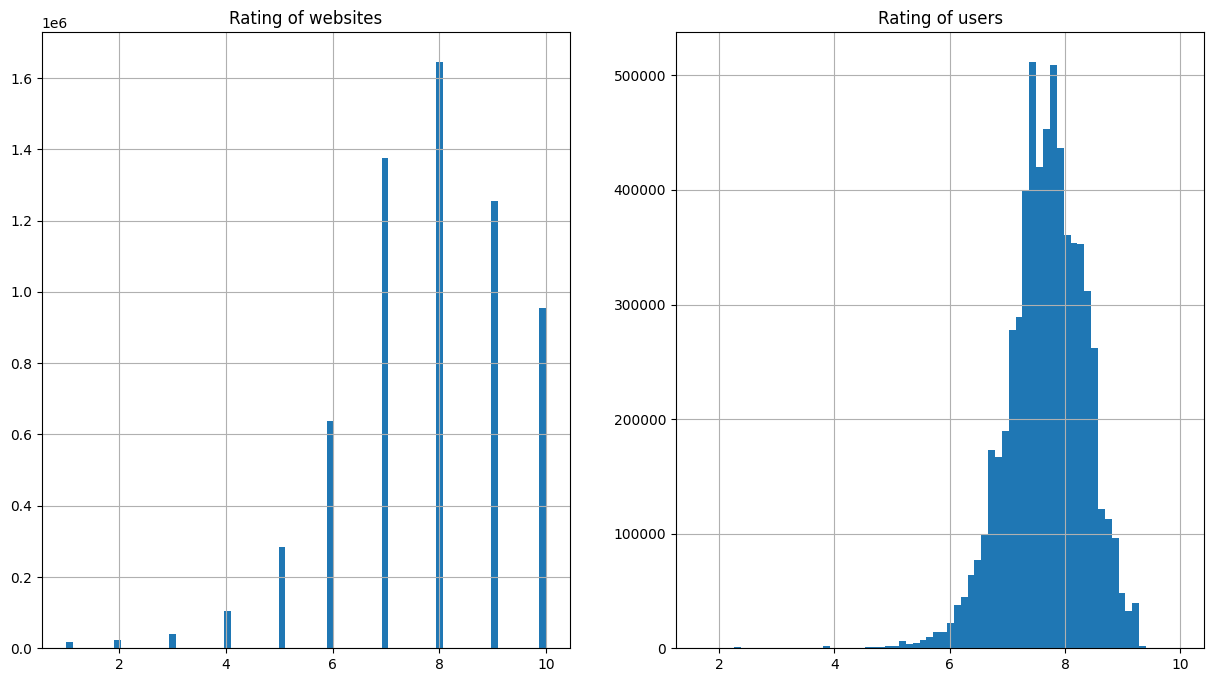

In [21]:
plt.figure(figsize = (15, 8))
plt.subplot(1,2,1)
df['user_rating'].hist(bins=70)
plt.title("Rating of websites")
plt.subplot(1,2,2)
df['rating_x'].hist(bins=70)
plt.title("Rating of users")


(-0.5, 799.5, 399.5, -0.5)

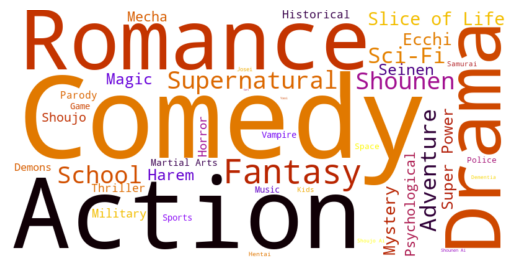

In [22]:
nonull_anime = df.copy()
nonull_anime.dropna(inplace=True)

all_genres = defaultdict(int)
for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1        

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

In [23]:
anime_feature=df.copy()
anime_feature["user_rating"].replace({-1: np.nan}, inplace=True)
anime_feature.head()

,anime_id,anime_name,genre,type,episodes,rating_x,members,user_id,user_rating,total_rating_count
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0,1961
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0,1961
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0,1961
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0,1961
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0,1961


In [24]:
anime_feature = anime_feature.dropna(axis = 0, how ='any') 
anime_feature.isnull().sum()

anime_id              0
anime_name            0
genre                 0
type                  0
episodes              0
rating_x              0
members               0
user_id               0
user_rating           0
total_rating_count    0
dtype: int64

In [25]:
anime_feature['user_id'].value_counts()

user_id
42635.0    3747
53698.0    2905
57620.0    2689
59643.0    2632
51693.0    2620
           ... 
41324.0       1
11199.0       1
19041.0       1
26082.0       1
62930.0       1
Name: count, Length: 69600, dtype: int64

In [26]:
counts = anime_feature['user_id'].value_counts()
anime_feature = anime_feature[anime_feature['user_id'].isin(counts[counts >= 200].index)]

In [27]:
anime_pivot=anime_feature.pivot_table(index='anime_name',columns='user_id',values='user_rating').fillna(0)
anime_pivot.head()

user_id,5.0,7.0,17.0,38.0,43.0,46.0,123.0,129.0,139.0,160.0,...,73406.0,73417.0,73422.0,73457.0,73460.0,73476.0,73499.0,73502.0,73503.0,73507.0
anime_name,,,,,,,,,,,,,,,,,,,,,
&quot;0&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
&quot;Eiji&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:

anime_matrix = csr_matrix(anime_pivot.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [29]:
query_index = np.random.choice(anime_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

9006


In [30]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(anime_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, anime_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for UFO Princess Valkyrie 4: Toki to Yume to Ginga no Utage:

1: UFO Princess Valkyrie 3: Seiresetsu no Hanayome, with distance of 0.09233541048251603:
2: UFO Princess Valkyrie 2: Juunigatsu no Yasoukyoku, with distance of 0.16488468487782248:
3: UFO Princess Valkyrie, with distance of 0.26106735721087204:
4: UFO Princess Valkyrie: Special, with distance of 0.3055171997634134:
5: UFO Princess Valkyrie: Recap, with distance of 0.6481238489788864:


In [31]:
anime_data=movie

In [32]:

def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_data['name'] = anime_data['name'].apply(text_cleaning)

In [33]:

tfv = TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),stop_words = 'english')

# Filling NaNs with empty string
anime_data['genre'] = anime_data['genre'].fillna('')
genres_str = anime_data['genre'].str.split(',').astype(str)
tfv_matrix = tfv.fit_transform(genres_str)

In [34]:
tfv_matrix.shape

(12294, 1554)

In [35]:

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [36]:
indices = pd.Series(anime_data.index, index=anime_data['name']).drop_duplicates()

In [37]:
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    anime_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,'Rating': anime_data['rating'].iloc[anime_indices].values})

In [38]:
give_rec('0')

,Anime name,Rating
0,Kyoukai no Kanata Movie: Ill Be Here - Kako-he...,7.92
1,Snow Halation,7.61
2,Perfect Day,7.59
3,Higashi no Eden: Falling Down,7.56
4,Macross F Music Clip Shuu: Nyankuri,7.47
5,ef: A Tale of Melodies. - Prologue,7.43
6,Koi ni Naritai Aquarium,7.43
7,Wonderful Rush,7.40
8,Kimi no Kokoro wa Kagayaiteru kai?,7.35
9,"Natsu-iro Egao de 1, 2, Jump!",7.34


In [40]:
pickle.dump(anime_data.to_dict(),open('movie_dict.pk1','wb'))

NameError: name 'pickle' is not defined

In [ ]:
pickle.dump(tfv_matrix,open('tfv.pk1','wb'))
pickle.dump(anime_data.to_dict(),open('anime_data.pk1','wb'))

In [ ]:
pickle.dump(indices,open('indices.pk1','wb'))

In [ ]:
anime_data.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [ ]:
id_list=anime_data.loc[lambda anime_data:anime_data['name']=='Ginga Eiyuu Densetsu']

In [ ]:
id=id_list['anime_id']